# Introduction

Using the development version of [scikit-learn](http://scikit-learn.org/dev/documentation.html), we construct a neural network (NN) regression model to map from a quantum mechanical potential to the energy levels (eigenvalues) for the single-particle system. The potential $V(x)$ is defined in the range $x\in [-1,1]$ and has the boundary conditions $V(\pm 1) = \infty$. 

The potentials used for training and testing are generated in [potentials.ipynb](potentials.ipynb). The eigenvalues for all potentials are calculated in [eigenvalues.ipynb](eigenvalues.ipynb).

# Preliminaries

In [ ]:
%matplotlib inline
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

In [66]:
# Number of basis states for the wavefunctions
NBW = 50
nbws = np.arange(1, NBW+1)
# Number of potentials:
NV = int(1E5)
# Number of basis states in the potential:
NB = 10
ns = np.arange(1, NB+1)
# lambda (variance of Legendre coefficients):
lam = 0.75
# The variance of the n=0 legendre coefficient V_0:
V20 = 10

# Input file:
filepath = "../Data/eigenvalues_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
filepathSD = "../Data/eigenvaluesSD_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
data = np.load(filepath)
dataSD = np.load(filepathSD)
VSns = data[::,0:10]
VCns = data[::,10:20]
eigs = data[::,20::]

In [68]:
print("Data shape: ", data.shape, 
      "\nSine coefficients shape: ", VSns.shape,
      "\nCosine coefficients shape: ", VCns.shape, eigs.shape,
      "\nStd. dev. shape: ", dataSD.shape
     )

Data shape:  (100000, 60) 
Sine coefficients shape:  (100000, 10) 
Cosine coefficients shape:  (100000, 10) (100000, 40) 
Std. dev. shape:  (40,)


# Preprocessing

We know that the spectrum is symmetric under $x\to -x$. We can build this into our dataset. To do this, we duplicate the entire dataset but set all the Sine coefficients to their negative value. This is equivalent to taking $x\to-x$.

We extract the values of the potentials at a discreet, linear grid of $x$ points: $\left\{V(x) \,\, \mid \,\, x \in \{x_1,\,x_2,\ldots,x_{N_x}\}\right\}$. This grid of potential values will serve as the input to our NN model.

In [102]:
# We first define functios that help us map the Fourier-space potentials into coordinate space.
def VS(ns, xs):
    return np.sin(np.pi*np.outer(ns,xs))
def VC(ns, xs):
    return np.cos(np.pi*np.outer(ns,xs))

In [103]:
# Number of x coordinates:
Nx = 100
xs = np.linspace(-1,1,Nx)

# The coordinate space potentials:
VSs = VS(ns,xs)
VCs = VC(ns,xs)
Vgrid = np.dot(VSns,VSs) + np.dot(VCns,VCs)
VgridFlipped = np.dot(-VSns,VSs) + np.dot(VCns,VCs)

# Make sure the flip worked by looking at a random potential:
rint = randint(0, NV)
print("First 4 values of Vgrid["+str(rint)+"]:" , Vgrid[rint][0:4])
print("Last 4 values of VgridFlipped["+str(rint)+"]:", VgridFlipped[rint][-4::])

First 4 values of Vgrid[17176]: [ 6.6721974   6.40114595  6.21545834  6.1036904 ]
Last 4 values of VgridFlipped[17176]: [ 6.1036904   6.21545834  6.40114595  6.6721974 ]


In [104]:
numeigs = 10
X = np.concatenate( (Vgrid, VgridFlipped) )
y = np.concatenate( (eigs, eigs) )[::,1:numeigs+1]

In [110]:
# Split test and train
test_frac = 0.4
random_state = 5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=random_state
)
print("X shape, y shape: ", X.shape, y.shape)
print("X_train shape, y_train shape: ", X_train.shape, y_train.shape)
print("X_test shape, y_test shape: ", X_test.shape, y_test.shape)

X shape, y shape:  (200000, 100) (200000, 10)
X_train shape, y_train shape:  (120000, 100) (120000, 10)
X_test shape, y_test shape:  (80000, 100) (80000, 10)


# Neural network

Documentation for `sklearn`'s supervised NN tools can be found here: http://scikit-learn.org/dev/modules/neural_networks_supervised.html

In [116]:
# Initialize the NN regression model
from sklearn.neural_network import MLPRegressor
hidden_layers = (50,30)
regr =MLPRegressor(hidden_layer_sizes=hidden_layers,
                  activation = 'tanh',
                  algorithm = 'adam',
                  alpha = 0.0001,
                  batch_size = 'auto',
                  #learning_rate = 'adaptive',
                  max_iter = 2000,
                  tol = 1e-7,
                  learning_rate_init = 0.001,
                  verbose = True
                 )

In [117]:
regr.fit(X_train, y_train);

Iteration 1, loss = 0.02760305
Iteration 2, loss = 0.00519889
Iteration 3, loss = 0.00308179
Iteration 4, loss = 0.00207147
Iteration 5, loss = 0.00146411
Iteration 6, loss = 0.00110669
Iteration 7, loss = 0.00090201
Iteration 8, loss = 0.00074885
Iteration 9, loss = 0.00065623
Iteration 10, loss = 0.00058790
Iteration 11, loss = 0.00053402
Iteration 12, loss = 0.00049398
Iteration 13, loss = 0.00046354
Iteration 14, loss = 0.00043657
Iteration 15, loss = 0.00041328
Iteration 16, loss = 0.00040472
Iteration 17, loss = 0.00039241
Iteration 18, loss = 0.00037580
Iteration 19, loss = 0.00037293
Iteration 20, loss = 0.00035900
Iteration 21, loss = 0.00035435
Iteration 22, loss = 0.00034761
Iteration 23, loss = 0.00033901
Iteration 24, loss = 0.00032432
Iteration 25, loss = 0.00031756
Iteration 26, loss = 0.00032243
Iteration 27, loss = 0.00031026
Iteration 28, loss = 0.00030597
Iteration 29, loss = 0.00029915
Iteration 30, loss = 0.00029408
Iteration 31, loss = 0.00028162
Iteration 32, los

We now test the NN on the test set. We measure the error for each eigenvalue relative to the width of the distribution of that eigenvalue over all of the generated potentials. Alternatively (and similarly) one could measure the error relative to the error incurred by simply guessing that the correct value equaled the uniform square-well value.

In [118]:
y_pred = regr.predict(X_test)
y_scaled_err = np.sqrt(np.mean((y_pred - y_test)**2/dataSD[0:numeigs]**2, axis = 0))
print("Scaled RMS error by eigenvalue:\n", y_scaled_err)
print("Average of scaled RMS errors:\n ", np.mean(np.abs(y_scaled_err)))

Scaled RMS error by eigenvalue:
 [ 0.06609608  0.07229769  0.08769723  0.1075714   0.12855204  0.16505261
  0.19767788  0.21197284  0.21532696  0.14533833]
Average of scaled RMS errors:
  0.13975830453


Save the network:

In [100]:
from sklearn.externals import joblib
# Input file:
filepath = "../Data/NN/NN" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".pkl"
joblib.dump(regr, filepath);

# Visualizing the results

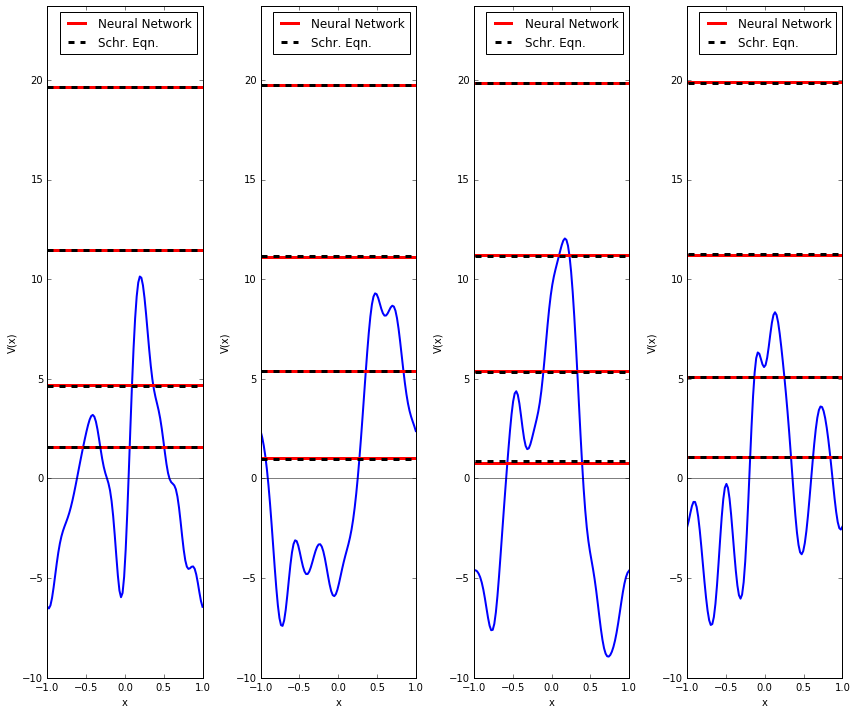

In [101]:
nrows = 1
ncols = 4
nplot = nrows * ncols
indplt = randint(0,X_test.shape[0], nplot)
numeigsplt = 4

def E0(n):
    return n**2 * np.pi**2 / 8.

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(3*ncols,10*nrows)
subax = axes.flat

for i in range(0, len(indplt)):
        subax[i].plot(xs, X_test[indplt[i]], linewidth = 2, label='$V(x)$')
        subax[i].axhline(y=0,xmin=-1,xmax=1, linestyle='solid' ,color = 'k', lw=0.5)
        for j in range(0, numeigsplt):
            lastaxNN = subax[i].axhline(y=E0(j+1)+y_pred[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'solid', color = 'r', lw = 3, label = 'Neural Network')
            lastaxSE = subax[i].axhline(y=E0(j+1)+y_test[indplt[i],j], xmin = -1, xmax = 1, 
                             ls = 'dashed', color = 'k', lw =3, label = 'Schr. Eqn.')

        subax[i].set_xlabel("x")
        subax[i].set_ylabel("V(x)")
        subax[i].set_ylim((-V20, 1.2*E0(numeigsplt)))
        subax[i].legend([lastaxNN, lastaxSE], ["Neural Network", "Schr. Eqn."])

plt.tight_layout();
plt.show();
plt.draw()
fig.savefig("../Plots/NNPred.png")